In [152]:
import scipy.io
from scipy.stats import ks_2samp,spearmanr

from sklearn.metrics import r2_score

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

from game import Game
from strategies import BaseStrategy

import torch
from tqdm import tqdm

from fiftyone import ViewField as F

import math

# Functions

In [153]:
def build_inner_indices(size):
    size = int(np.sqrt(size))
    indices = []
    for i in range(1, size-1):
        for j in range(1, size-1):
            indices.append(np.ravel_multi_index((i, j), (size, size)))
    return indices


In [155]:
def compute_p_values(b_df, r_df, metric, match=0, filter_in=False):
    b_df = b_df[b_df['match'] == match]
    b_df = b_df[b_df['random_match'] == 0]
    r_df = r_df[r_df['match'] == match]
    r_df = r_df[r_df['random_match'] == 0]
    b_grouped = b_df.groupby('board_size')
    r_grouped = r_df.groupby('board_size')
    for (b_bs, b_group), (r_bs, r_group) in zip(b_grouped, r_grouped):
        if filter_in:
            b_group = b_group[b_group['tile_clicked'].isin(build_inner_indices(b_bs))]
            r_group = r_group[r_group['tile_clicked'].isin(build_inner_indices(r_bs))]
        b_array = b_group[metric].to_numpy()
        r_array = r_group[metric].to_numpy()
        statistic, p_value = ks_2samp(b_array, r_array)
        print(f'---- Board Size: {b_bs} ----')
        print(f'Ratio b/m: {len(b_array) / len(r_array)}')
        print("KS statistic:", statistic)
        print("p-value:", p_value)
        print('\n')

In [156]:
def euclidean_distance(row):
    N = int(np.sqrt(row['board_size']))
    # Convert 1D indices to 2D coordinates
    x1, y1 = np.unravel_index(row['tile_clicked'], (N, N))
    x2, y2 = np.unravel_index(row['correct_tile'], (N, N))
    
    # Compute Euclidean distance
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    return distance

In [157]:
def add_distances(df):
    df = df[df['correct_tile'] >= 0]
    df['distance'] = df.apply(euclidean_distance, axis=1)
    return df

# Get behavioural DF

In [158]:
PATH = '/home/ravi/Models-of-Working-Memory/b_data/matlab_code/P00_data_behavior'

In [159]:
pat = scipy.io.loadmat(f'{PATH}/b_data_subject_1')

In [160]:
def build_tile_df(N=20):
    dfs = []
    for i in range(N):
        pat = scipy.io.loadmat(f'{PATH}/b_data_subject_{i+1}')
        pat = pat['b_data'][0]
        match = pat[0][1].flatten()
        random_match = pat[1][1].flatten()
        tile_clicked = pat[11][1].flatten()[1::2]
        board_size = pat[6][1].flatten()[1::2]
        correct_tile = pat[12][1].flatten()[0::2]
        nslc = pat[3][1].flatten()[1::2]
        nsp = pat[2][1].flatten()[1::2]
        
        categories = {0: 'z', 1: 'animal', 2: 'food', 3: 'indoor', 4: 'person', 5: 'vehicle'}        
        img_category = pat[10][1].flatten()
        img_category = np.vectorize(categories.get)(img_category)

        dfs.append(pd.DataFrame({
            'match': match,
            'random_match': random_match,
            'tile_clicked': tile_clicked-1,
            'board_size': board_size,
            'correct_tile': correct_tile-1,
            'clicked_category': img_category[1::2],
            'corr_category': img_category[0::2],
            'nslc': nslc,
            'nsp': nsp,
            'patient': i+1,
        }))
    return pd.concat(dfs).reset_index(drop=True)

In [161]:
b_df = build_tile_df()
b_df = add_distances(b_df)
pd.set_option('display.max_rows', None)
# b_df[8:100].reset_index(drop=True)[1:]

/tmp/ipykernel_4036179/1637944754.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(euclidean_distance, axis=1)


# Get random model DF

In [162]:
n_trials = 20

size_range = [[3,3], [4,4], [5,5], [6,6], [7,7]]

In [163]:
def get_second_click_df(df):
    o_df = pd.DataFrame()
    o_df['match'] = df['match'].to_numpy()[1::2]
    o_df['random_match'] = df['random_match'].to_numpy()[1::2]
    o_df['board_size'] = df['board_size'].to_numpy()[1::2]
    o_df['tile_clicked'] = df['tile_clicked'].to_numpy()[1::2]
    o_df['nslc'] = df['nslc'].to_numpy()[1::2]
    o_df['nsp'] = df['nsp'].to_numpy()[1::2]
    o_df['correct_tile'] = df['correct_tile'].to_numpy()[0::2]
    return o_df

In [164]:
def play_strategy(strategy, game):
    win = False
    while not win:
        strategy.pick()
        win = game.check_win()
        torch.cuda.empty_cache()

In [165]:
def collect_data(n_trials, size_range, game):
    dfs = []
    tot_clicks = []
    for size in size_range:
        size_clicks = []
        for n in tqdm(range(n_trials), desc=f'Size: {size}'):
            game.set_size(size, 2)
            dim = np.prod(size) + len(np.unique(game.get_grid_labels()))
            # dim = 74
            strategy = BaseStrategy(game)
            play_strategy(strategy, game)
            df, nc = game.get_metrics()
            dfs.append(df)
            size_clicks.append(nc)
        tot_clicks.append(size_clicks)
    return pd.concat(dfs).reset_index(drop=True), tot_clicks

In [166]:
game = Game(
            dataset_name='coco-2017', 
            split='validation', 
            field="ground_truth", 
            ds_filter=F("supercategory").is_in(('person', 'animal', 'food', 'vehicle', 'indoor')),
            dataset_dir ="/home/ravi/datasets/coco-2017",
        )

Found annotations at '/home/ravi/datasets/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [167]:
t_df, _ = collect_data(n_trials, size_range, game)
r_df = get_second_click_df(t_df)
r_df = add_distances(r_df)

Size: [7, 7]: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]
/tmp/ipykernel_4036179/1637944754.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = df.apply(euclidean_distance, axis=1)


# P-vals

In [168]:
compute_p_values(b_df, r_df, 'tile_clicked', 0)

---- Board Size: 9 ----
Ratio b/m: 0.2601626016260163
KS statistic: 0.08460365853658537
p-value: 0.983852559677169


---- Board Size: 16 ----
Ratio b/m: 0.14228456913827656
KS statistic: 0.10069434643935758
p-value: 0.14896282348996134


---- Board Size: 25 ----
Ratio b/m: 0.20191055145462442
KS statistic: 0.06988920482400235
p-value: 0.04321752447213955


---- Board Size: 36 ----
Ratio b/m: 0.13022151898734177
KS statistic: 0.04167217804574188
p-value: 0.15454920112572118


---- Board Size: 49 ----
Ratio b/m: 0.5947705554972172
KS statistic: 0.06239232135578982
p-value: 1.8275887861596338e-12




In [169]:
compute_p_values(b_df, r_df, 'tile_clicked', 1)

---- Board Size: 9 ----
Ratio b/m: 1.0441176470588236
KS statistic: 0.09755592377796189
p-value: 0.8458275739996116


---- Board Size: 16 ----
Ratio b/m: 1.135135135135135
KS statistic: 0.08333333333333333
p-value: 0.6059153633674372


---- Board Size: 25 ----
Ratio b/m: 1.8849557522123894
KS statistic: 0.06554073704765466
p-value: 0.5224746416602392


---- Board Size: 36 ----
Ratio b/m: 1.4757834757834758
KS statistic: 0.06448756448756449
p-value: 0.3307469501284951


---- Board Size: 49 ----
Ratio b/m: 6.561702127659575
KS statistic: 0.05234566879156663
p-value: 0.20554781559618626




# Comparison inner grid

In [170]:
compute_p_values(b_df, r_df, 'tile_clicked', 0, filter_in=True)

---- Board Size: 9 ----
Ratio b/m: 0.2727272727272727
KS statistic: 0.0
p-value: 1.0


---- Board Size: 16 ----
Ratio b/m: 0.1834862385321101
KS statistic: 0.05229357798165138
p-value: 0.9999001735452624


---- Board Size: 25 ----
Ratio b/m: 0.2256169212690952
KS statistic: 0.08807652761457109
p-value: 0.16431446354979756


---- Board Size: 36 ----
Ratio b/m: 0.14340544312630846
KS statistic: 0.07099087718583341
p-value: 0.05057569929183507


---- Board Size: 49 ----
Ratio b/m: 0.700961118392311
KS statistic: 0.05100456734765059
p-value: 0.00010417395394781226




In [171]:
compute_p_values(b_df, r_df, 'tile_clicked', 1, filter_in=True)

---- Board Size: 9 ----
Ratio b/m: 1.5
KS statistic: 0.0
p-value: 1.0


---- Board Size: 16 ----
Ratio b/m: 1.2222222222222223
KS statistic: 0.1691919191919192
p-value: 0.5563103247063635


---- Board Size: 25 ----
Ratio b/m: 1.697674418604651
KS statistic: 0.1350748646065626
p-value: 0.2481837096564869


---- Board Size: 36 ----
Ratio b/m: 1.4503311258278146
KS statistic: 0.03764855302549215
p-value: 0.9988650058740531


---- Board Size: 49 ----
Ratio b/m: 6.113360323886639
KS statistic: 0.034592594578652436
p-value: 0.9525012111957946




# Distance comparison

In [172]:
def plot_error_distance(b_df, r_df):

    b_df['board_size'] = b_df['board_size'].apply(np.sqrt)
    b_df = b_df[b_df['match']==0]
    b_df = b_df[b_df['correct_tile'] >= 0]
    b_df['Data'] = 'Behavioral'
    
    r_df['board_size'] = r_df['board_size'].apply(np.sqrt)
    r_df = r_df[r_df['match']==0]
    r_df = r_df[r_df['correct_tile'] >= 0]
    r_df['Data'] = 'Model'
    
    l = []
    # r_m = b_df[(b_df['nsp'] <= 0)]
    # r_m['Data'] = f'Random match'
    # l.append(r_m)
    # for nsl_a, nsl_b in [[0,1], [1, 2], [2,3], [3, 5], [5, 10], [10, 100]]:
    #     nsl = b_df[(b_df['nslc'] > nsl_a) & (b_df['nslc'] <= nsl_b)]
    #     nsl['Data'] = f'Behavioral (nslc in ({nsl_a}, {nsl_b}])'
    #     l.append(nsl)

    l.append(b_df)
    l.append(r_df)

    df = pd.concat(l)

    # palette = list(sns.color_palette("Blues"))[::-1] + ['red'] + ['green']
    palette = ['red'] + ['green']
    plt.figure(figsize=(16, 16))
    #palette = ['grey']
    ax = sns.catplot(x="board_size", y="distance", hue='Data', data=df, aspect=0.85, kind='bar', palette=palette)
    ax.set(xlabel="Board size", ylabel="distance-from-correct")
    plt.show()

<Figure size 1600x1600 with 0 Axes>

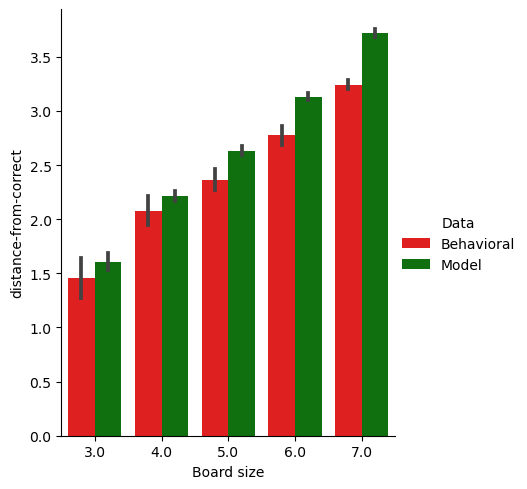

In [173]:
plot_error_distance(b_df, r_df)